In [1]:
# Import the necessary components
from epydemix import EpiModel
from epydemix.visualization import plot_quantiles
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Defining a basic SIR model
sir_model = EpiModel(
    name='SIR Model',
    compartments=['S', 'I', 'R'],  # Susceptible, Infected, Recovered
    parameters={
        'beta': 0.3,  # Transmission rate
        'gamma': 0.1  # Recovery rate
    }
)

# Defining the transitions
sir_model.add_transition(source='S', target='I', rate='beta', agent='I')
sir_model.add_transition(source='I', target='R', rate='gamma')

print(sir_model)

EpiModel(name='SIR Model')
Compartments: 3
  S, I, R
Transitions: 2
  Transitions between compartments:
    S -> I, rate: beta
    I -> R, rate: gamma
Parameters: 2
  Model parameters:
    beta: 0.3
    gamma: 0.1
Population: epydemix_population
  Population size: 100000 individuals
  Demographic groups: 1
    0



In [7]:
# Initial conditions
initial_conditions = {
    'S': 100000-10,  
    'I': 10,   
    'R': 0     
}

# running the simulations
sir_results = sir_model.run_simulations(
    start_date="2024-01-01",
    end_date="2024-04-10",
    initial_conditions_dict=initial_conditions,
    Nsim=10,
    resample_frequency="3min", 
    dt = 1/3
)

In [8]:
sir_results.get_df_quantiles()

,S_0,S_total,I_0,I_total,R_0,R_total,quantile,date
0,99987.450,99987.450,9.225,9.225,0.000,0.000,0.025,2024-01-01 00:00:00
1,99987.450,99987.450,9.225,9.225,0.000,0.000,0.025,2024-01-01 00:03:00
2,99987.450,99987.450,9.225,9.225,0.000,0.000,0.025,2024-01-01 00:06:00
3,99987.450,99987.450,9.225,9.225,0.000,0.000,0.025,2024-01-01 00:09:00
4,99987.450,99987.450,9.225,9.225,0.000,0.000,0.025,2024-01-01 00:12:00
...,...,...,...,...,...,...,...,...
336002,6174.725,6174.725,1458.625,1458.625,93214.700,93214.700,0.975,2024-04-09 23:48:00
336003,6174.725,6174.725,1458.625,1458.625,93214.700,93214.700,0.975,2024-04-09 23:51:00
336004,6174.725,6174.725,1458.625,1458.625,93214.700,93214.700,0.975,2024-04-09 23:54:00
336005,6174.725,6174.725,1458.625,1458.625,93214.700,93214.700,0.975,2024-04-09 23:57:00


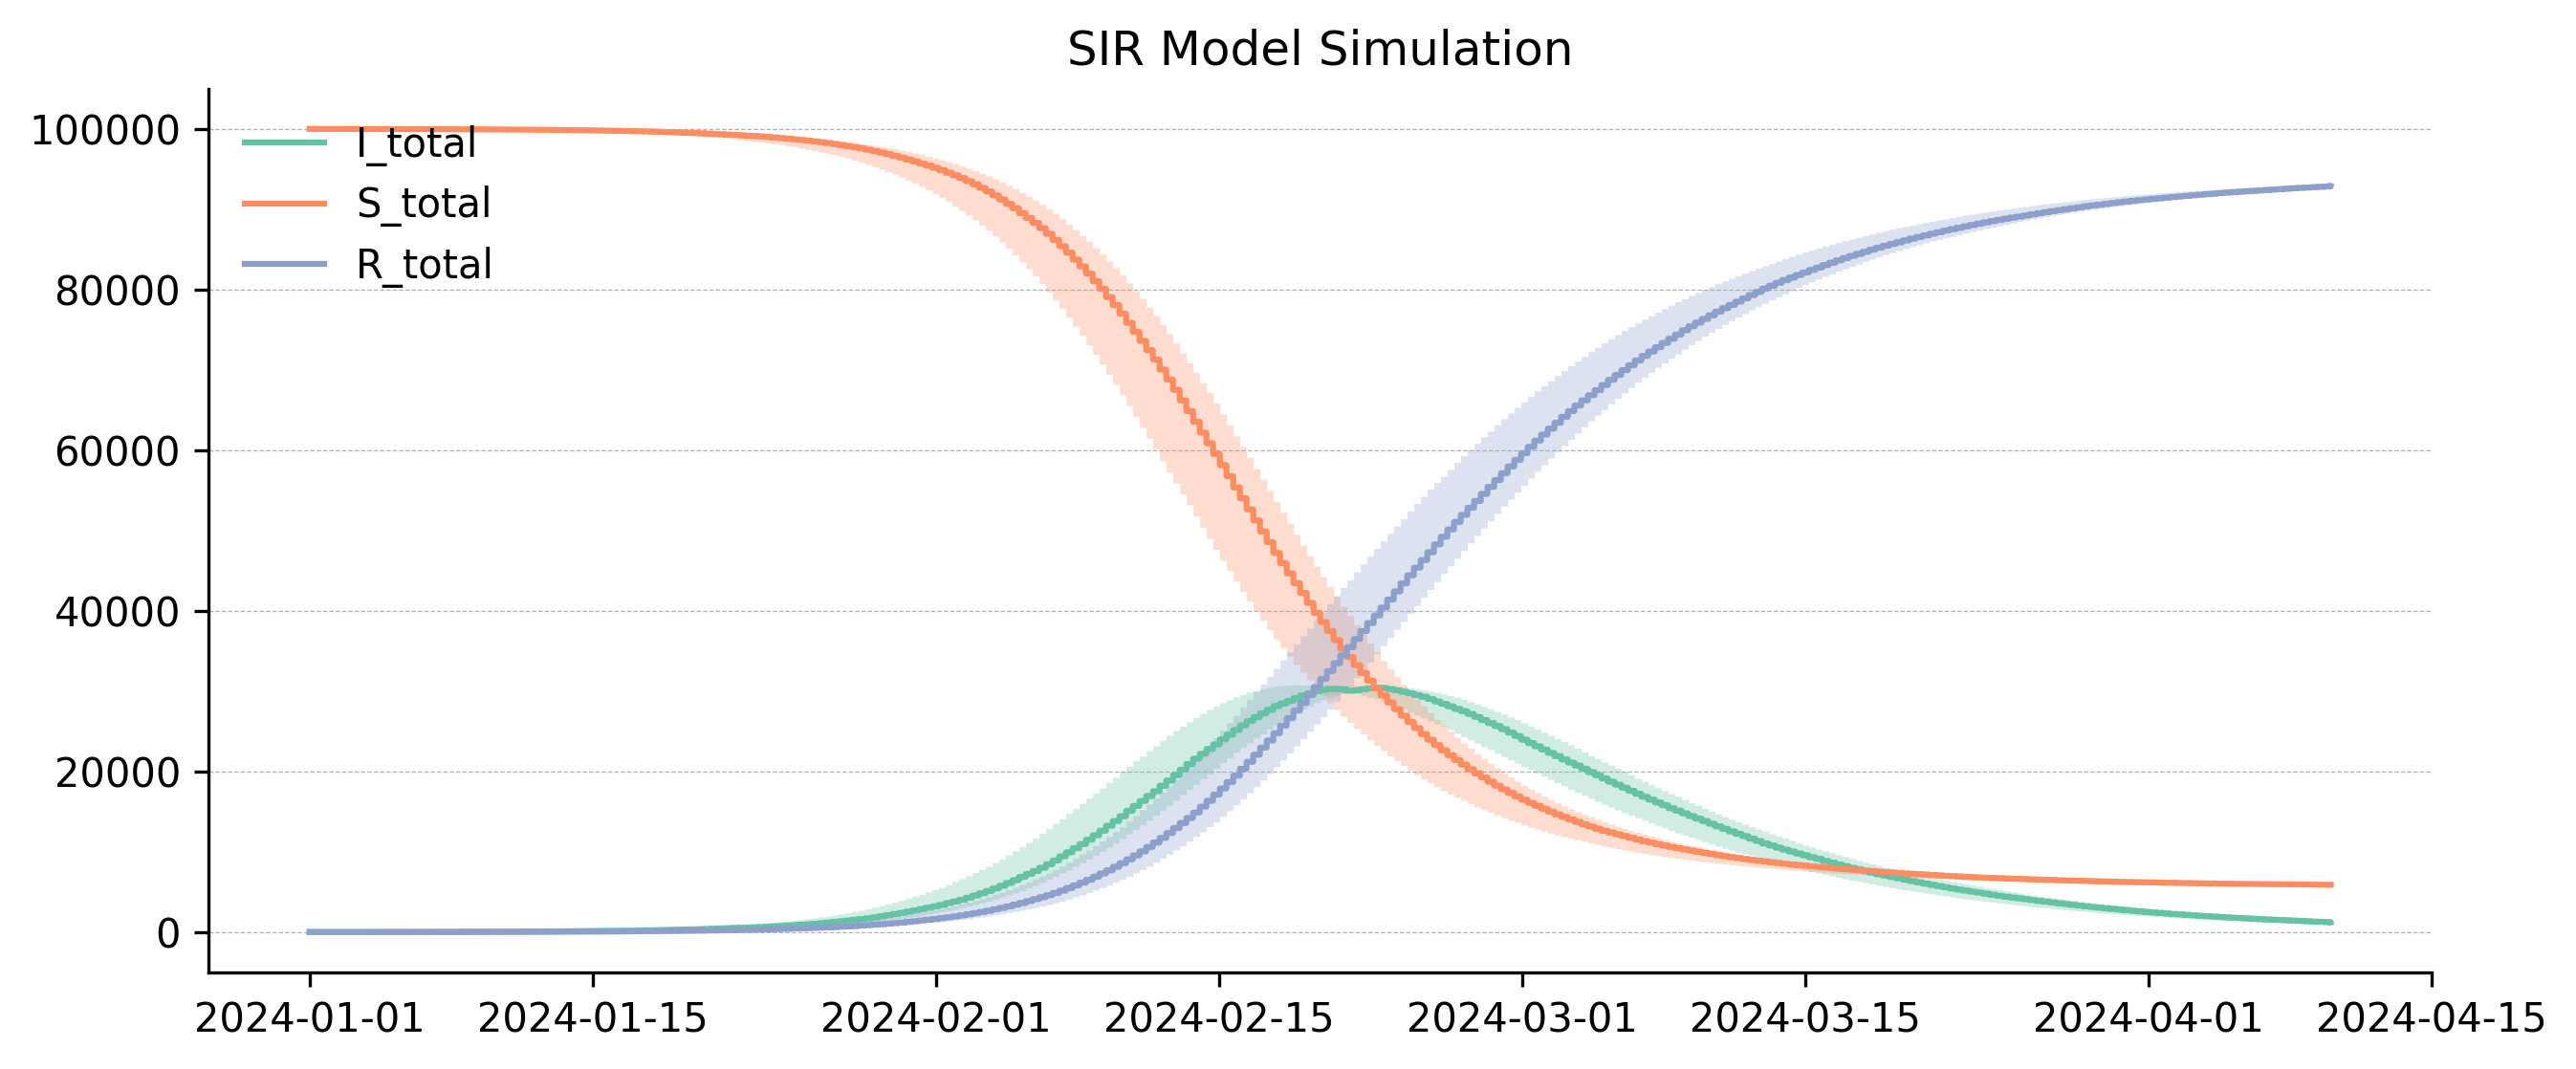

In [9]:
plot_quantiles(sir_results, columns=["I_total", "S_total", "R_total"], title='SIR Model Simulation')

In [ ]:
plot_quantiles(sir_results, columns=["I_total", "S_total", "R_total"], title='SIR Model Simulation')